In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler
from torchvision import transforms, utils
from PIL import Image
import tifffile as tiff
import time
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import skimage
from skimage.transform import resize
import io
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda'

In [3]:
# TODO
def preprocess_images(gt_img_path):
    gt_img = Image.open(gt_img_path)
    gt_img = gt_img.resize((256, 256))


In [4]:
class SegmentationDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, device, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        gt_img_path = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        gt_img = Image.open(gt_img_path)
        gt_img = gt_img.resize((256, 256))
        # gt_img = transforms.ToTensor()(gt_img)

        gt_img = skimage.img_as_float(gt_img)

        gt_img = torch.from_numpy(gt_img).unsqueeze(0)
        gt_img = np.array(gt_img).astype(np.float32)

        gt_img = torch.tensor(gt_img, dtype=torch.float32)



        femur_mask_img_path = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 1])
        
        femur_mask_img = Image.open(femur_mask_img_path)
        femur_mask_img = femur_mask_img.resize((256, 256))
        femur_mask_img = transforms.ToTensor()(femur_mask_img)

        # Convert to mask
        femur_mask_img = (femur_mask_img> 0).to(torch.float32)

        # femur_mask_img = torch.tensor(femur_mask_img, dtype=torch.float32)
        femur_mask_img = femur_mask_img.clone().detach().float()
        

        tibia_mask_img_path = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 2])
        tibia_mask_img = Image.open(tibia_mask_img_path)
        tibia_mask_img = tibia_mask_img.resize((256, 256))
        tibia_mask_img = transforms.ToTensor()(tibia_mask_img)

        # Convert to mask
        tibia_mask_img = (tibia_mask_img> 0).to(torch.float32)

        # tibia_mask_img = torch.tensor(tibia_mask_img, dtype=torch.float32)
        tibia_mask_img = tibia_mask_img.clone().detach().float()


        bg = torch.ones((1,256,256), dtype=torch.float32)
        bg = bg - tibia_mask_img - femur_mask_img
        bg[bg < 0] = 0

        total_mask = torch.stack((bg.squeeze(0), femur_mask_img.squeeze(0), tibia_mask_img.squeeze(0))).unsqueeze(0)
        
        sample = {'xray': gt_img, 'femur_mask': femur_mask_img, 'tibia_mask': tibia_mask_img, "bg" : bg, "total_mask": total_mask}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\data\segnet_data.csv"
# path = r"K:\UZH\Spring 24\Sem Project\kneedeeppose\data\segmentation_test.csv"
dataset = SegmentationDataset(csv_file=path, root_dir="", device='cuda')

In [6]:
for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['xray'].size(), sample['femur_mask'].size(),  sample['tibia_mask'].size(), sample['bg'].size(), sample['total_mask'].size())

    if i == 2:
        break

0 torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 3, 256, 256])
1 torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 3, 256, 256])
2 torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 3, 256, 256])


In [7]:
dataloader = DataLoader(dataset, batch_size=30, shuffle=True)

In [43]:
samples = next(iter(dataloader))
xray = transforms.ToPILImage()(samples['xray'][0])


femur_mask = transforms.ToPILImage()(samples['femur_mask'][2])
tibia_mask = transforms.ToPILImage()(samples['femur_mask'][1])
bg_img = transforms.ToPILImage()(samples['bg'][2])
# total_mask = transforms.ToPILImage()(samples['total_mask'][2])




# plt.imshow(samples['image'][0][0])
# # plt.imshow(samples['mask'][0][0])

print(samples['xray'][0][0].dtype)
print(samples['femur_mask'][0][0].dtype)
print(samples['tibia_mask'][0][0].dtype)



torch.float32
torch.float32
torch.float32


In [44]:
# for sample in iter(dataloader):
#     print(sample["xray"].shape, sample["femur_mask"].shape, sample["tibia_mask"].shape)
#     print(sample["xray"].dtype, sample["femur_mask"].dtype, sample["tibia_mask"].dtype)

    


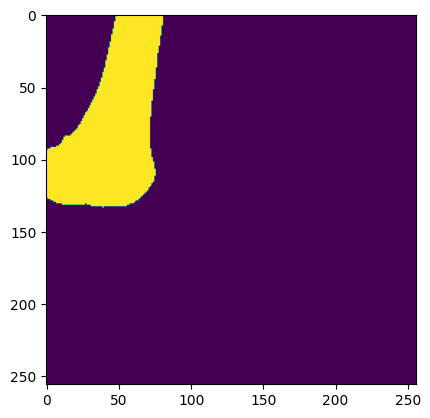

In [45]:
# plt.imshow(tibia_mask)
plt.imshow(femur_mask)
# plt.imshow(bg_img)
# print(femur_mask)

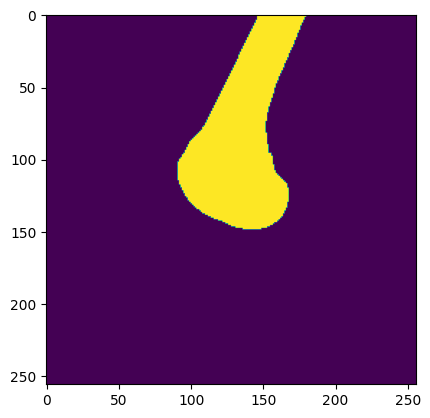

In [46]:
plt.imshow(tibia_mask)


In [47]:
samples['femur_mask'][2].shape


torch.Size([1, 256, 256])

tensor(13646)

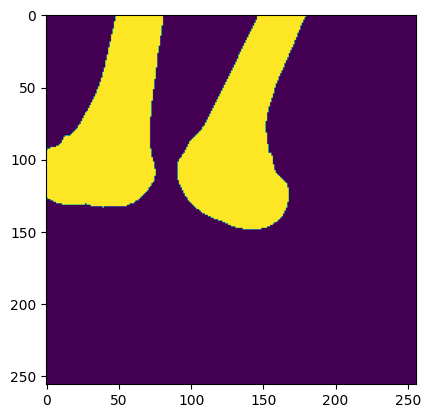

In [48]:
x = (samples['femur_mask'][2] - samples['femur_mask'][1]).abs() > 1e-3
plt.imshow(transforms.ToPILImage()(x * 1.0))
torch.sum(x)

In [52]:
from diffdrr.metrics import NormalizedCrossCorrelation2dMasked
metric = NormalizedCrossCorrelation2dMasked(256, 1e-3)

metric(samples['femur_mask'][1].unsqueeze(0), samples['femur_mask'][2].unsqueeze(0))

mask sum =  tensor(13646)


tensor([-0.5520])

In [30]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
def get_deeplab_model(device):
    outputchannels = 3
    # Initialize DeepLabV3 with a ResNet backbone
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    
    model.classifier = DeepLabHead(2048, outputchannels)
    model.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    
    model = model.to(device)  # Move model to GPU
    return model

In [31]:
m = get_deeplab_model(device)

test = torch.rand(2, 1,256,256, dtype=torch.float32, device=device)
op = m(test)
op["out"][0].shape

c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([3, 256, 256])

In [14]:
def train_model(model, criterion, dataloaders, val_loader, optimizer, metrics, 
                num_epochs):
    since = time.time()
    # best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    # with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
    #     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    #     writer.writeheader()
    phase = "Train"

    for epoch in range(1, num_epochs + 1):
        batchsummary = {a: [0] for a in fieldnames}
        model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        

        # for phase in ['Train', 'Test']:
        #     if phase == 'Train':
        #         model.train()  # Set model to training mode
        #     else:
        #         model.eval()  # Set model to evaluate mode

            # Iterate over data.
        for sample in tqdm(iter(dataloaders)):
        # for sample in iter(dataloaders):

            inputs = sample['xray'].to(device)
            masks = sample['total_mask'].to(device)
            masks = masks.squeeze(1)
            # print(inputs.shape)
            # print(masks.shape)
            # zero the parameter gradients
            optimizer.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                # print(outputs["out"].shape)
                loss = criterion(outputs['out'], masks)
                y_pred = outputs['out'].data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()
                for name, metric in metrics.items():
                    if name == 'f1_score':
                        # Use a classification threshold of 0.1
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true > 0, y_pred > 0.1))
                    else:
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true.astype('uint8'), y_pred))

                # backward + optimize only if in training phase
                if phase == 'Train':
                    loss.backward()
                    optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:5]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)

        # with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
        #     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        #     writer.writerow(batchsummary)
        #     # deep copy the model
        if phase == 'Train' and loss < best_loss:
            best_loss = loss
        #         best_model_wts = copy.deepcopy(model.state_dict())

        # ------------------- Validation Phase -------------------
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0

        # Evaluate on validation data
        with torch.no_grad():  # Disable gradient computation
            for sample in tqdm(val_loader):
                inputs = sample['xray'].to(device)
                masks = sample['total_mask'].to(device)
                masks = masks.squeeze(1)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs['out'], masks)

                # Compute metrics
                y_pred = outputs['out'].data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()

                # Update metrics
                for name, metric in metrics.items():
                    if name == 'f1_score':
                        batchsummary[f'Test_{name}'].append(metric(y_true > 0, y_pred > 0.1))
                    else:
                        batchsummary[f'Test_{name}'].append(metric(y_true.astype('uint8'), y_pred))

                # Statistics
                running_val_loss += loss.item() * inputs.size(0)

        # Calculate epoch loss for validation
        epoch_val_loss = running_val_loss / len(val_loader)
        batchsummary['Test_loss'] = epoch_val_loss
        print('Validation Loss: {:.4f}'.format(epoch_val_loss))

        # Average metrics for validation
        for field in fieldnames[5:]:
            batchsummary[field] = np.mean(batchsummary[field])

        print(batchsummary)
    
        # Check for best loss and save model weights if needed
        # if epoch_val_loss < best_loss:
        #     best_loss = epoch_val_loss
            # Uncomment if you want to save the best model weights
            # best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, batchsummary

In [15]:
def main(epochs, batch_size):
    # Create the deeplabv3 resnet101 model which is pretrained on a subset
    # of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
    model = get_deeplab_model(device)
    model.train()
    
    ## random sampler for overfitting
    # Define the subset of indices you want to sample
    # num_samples = int(len(dataset) * 0.01)  # 1% of the dataset
    # indices = torch.randperm(len(dataset))[:num_samples].tolist()
    # sampler = SubsetRandomSampler(indices)
    # dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    # Get indices for random split
    num_samples = len(dataset)
    indices = list(range(num_samples))

    # Random split (80% train, 20% validation)
    train_indices, val_indices = train_test_split(
        indices,
        test_size=0.2,  # 20% for validation
        random_state=42,  # For reproducibility
    )

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Specify the loss function
    criterion = torch.nn.MSELoss(reduction='mean')
    # Specify the optimizer with a lower learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Specify the evaluation metrics
    metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

    # Create the dataloader
    # dataloaders = datahandler.get_dataloader_single_folder(
    #     data_directory, batch_size=batch_size)
    model = train_model(model,
                    criterion,
                    train_loader,
                    val_loader,
                    optimizer,
                    # bpath=exp_directory,
                    metrics=metrics,
                    num_epochs=epochs)

    # Save the trained model
    # torch.save(model, exp_directory / 'weights.pt')
    return model


In [ ]:
model = main(epochs=10, batch_size=16)
torch.save(model.state_dict(), "checkpoints/segnet_27_9.ckpt")

torch.float32
torch.Size([2, 1, 256, 256])


C:\Users\Public Admin\AppData\Local\Temp\ipykernel_10128\467867436.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ip = torch.tensor(img, device=device)


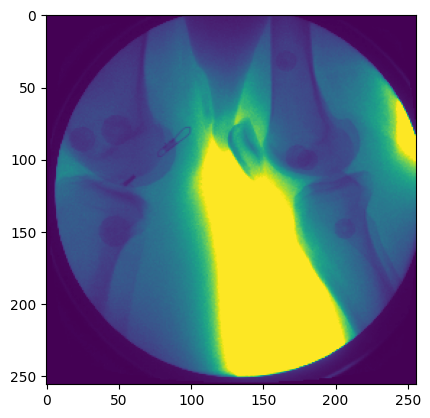

In [32]:
img = samples['xray'][6]
print(img.dtype)
ip = torch.tensor(img, device=device)
plt.imshow(transforms.ToPILImage()(img))
# plt.imshow(transforms.ToPILImage()(samples['femur_mask'][0]))
# plt.imshow(transforms.ToPILImage()(samples['tibia_mask'][0]))
ip = torch.stack((ip, ip))
print(ip.shape)


In [15]:
with torch.no_grad():
    output = m(ip)['out'][0]
print(output.shape)
output_predictions = output.argmax(0)
print(output_predictions.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256])


In [33]:
def show_mask(output_predictions):
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy())
    r.putpalette(colors)

    import matplotlib.pyplot as plt
    plt.imshow(r)
    plt.title("Femur and Tibia Masks from Segnet output")
    plt.show()
# show_mask(output_predictions)

In [17]:
def show_mask2(output_predictions):
    custom_colors = [
        (0, 0, 0),        # Class 0: Black (background)
        (0, 255, 255),      # Class 1: Red
        (128, 0, 128),      # Class 2: Green
    ]

    # Create a palette with the custom colors (3 classes)
    palette = torch.zeros(256, 3, dtype=torch.uint8)  # 256 colors for up to 256 classes, 3 channels (RGB)
    for class_idx, color in enumerate(custom_colors):
        palette[class_idx] = torch.tensor(color)

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy())
    r.putpalette(palette.numpy().flatten())

    import matplotlib.pyplot as plt
    plt.imshow(r)
    plt.title("Segmentation Masks")
    plt.show()
# show_mask(output_predictions)

In [50]:
def get_masked_img(img_tensor, mask_tensor, mask_num, device):
    print("1 masks",(mask_tensor==1).sum(dim=(1, 2)))
    print("2 masks",(mask_tensor==2).sum(dim=(1, 2)))
    print("zero masks",(mask_tensor==0).sum(dim=(1, 2)))
    print("img_tensor", img_tensor.dtype)
    print("img_tensor", img_tensor.shape)

    print("mask_tensor", mask_tensor.dtype)
    print("mask_tensor", mask_tensor.shape)
    img_tensor = img_tensor.to(device)
    op = []
    for img, mask in zip(img_tensor, mask_tensor):
        binary_mask = (mask == mask_num).float().to(device)
        masked_image = img * binary_mask
        op.append(masked_image)
    return torch.stack(op)

In [55]:
def get_masked_img2(img_tensor, mask_tensor, mask_num, device):
    print("img_tensor", img_tensor.dtype)
    print("img_tensor", img_tensor.shape)

    print("mask_tensor", mask_tensor.dtype)
    print("mask_tensor", mask_tensor.shape)



    print("1 masks",(mask_tensor==1).sum())
    print("2 masks",(mask_tensor==2).sum())
    print("zero masks",(mask_tensor==0).sum())


    img_tensor = img_tensor.to(device)
    op = []
    for img, mask in zip(img_tensor, mask_tensor):
        binary_mask = (mask == mask_num).float().to(device)
        masked_image = img * binary_mask

        plt.imshow(transforms.ToPILImage()(img), cmap="gray")
        plt.title("true xray")
        plt.show()
        # print('masked image', masked_image)
        plt.imshow(transforms.ToPILImage()(masked_image))
        plt.title("masked xray")
        plt.show()


        op.append(masked_image)
    return torch.stack(op)

img_tensor torch.float32
img_tensor torch.Size([2, 1, 256, 256])
mask_tensor torch.uint8
mask_tensor torch.Size([2, 256, 256])
1 masks tensor(31660)
2 masks tensor(73080)
zero masks tensor(26332)


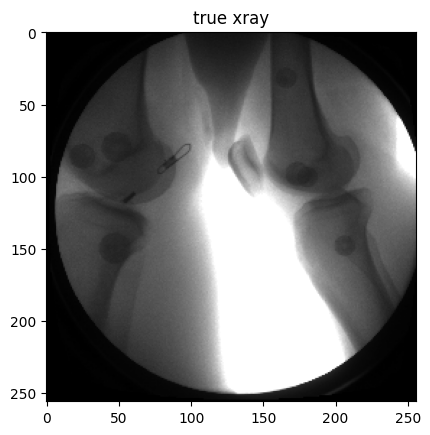

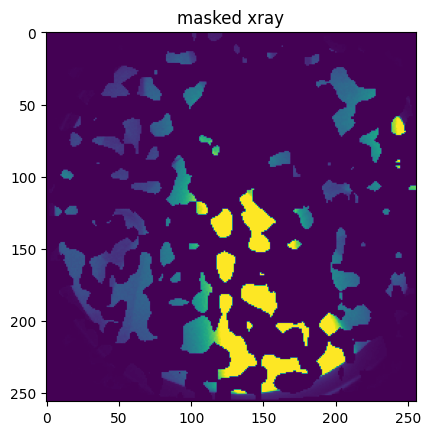

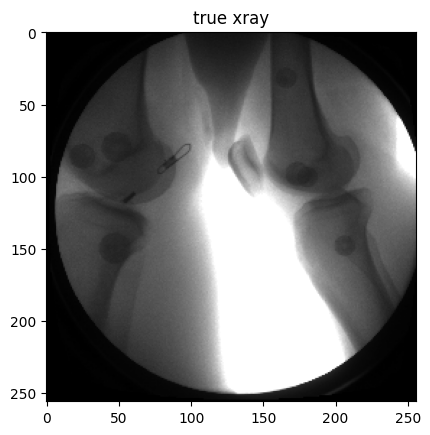

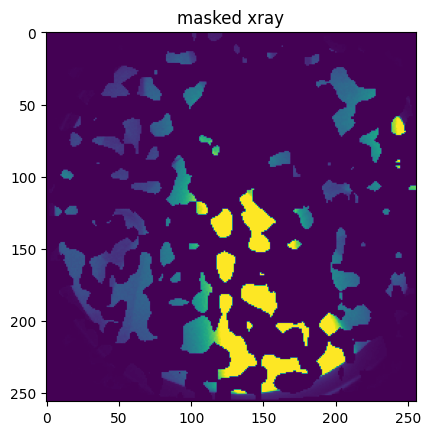

torch.Size([2, 1, 256, 256])
torch.float32


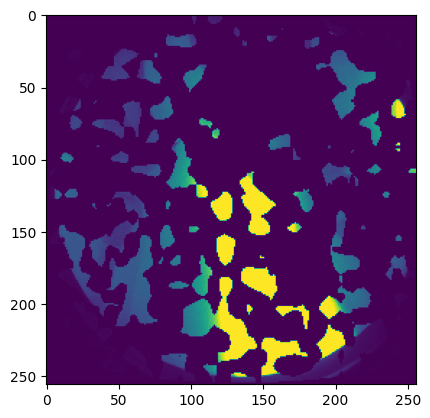

In [47]:
masks = output_predictions.byte().cpu()

test_stack_img = torch.stack([img.to(device), img.to(device)])
test_mask_stack = torch.stack([masks, masks])

crop_tensor = get_masked_img2(test_stack_img, test_mask_stack, 1, device)
print(crop_tensor.shape)
print(crop_tensor.dtype)
plt.imshow(transforms.ToPILImage()(crop_tensor[1]))

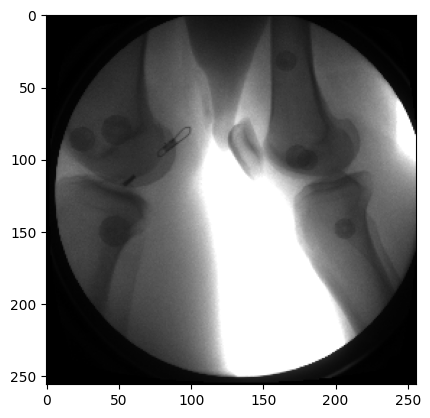

c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Public\Anaconda3\envs\DeepFluoro\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


output torch.Size([2, 3, 256, 256])
output_predictions torch.Size([2, 256, 256])
img_tensor torch.float32
img_tensor torch.Size([2, 1, 256, 256])
mask_tensor torch.uint8
mask_tensor torch.Size([2, 256, 256])
1 masks tensor(10479)
2 masks tensor(13148)
zero masks tensor(107445)


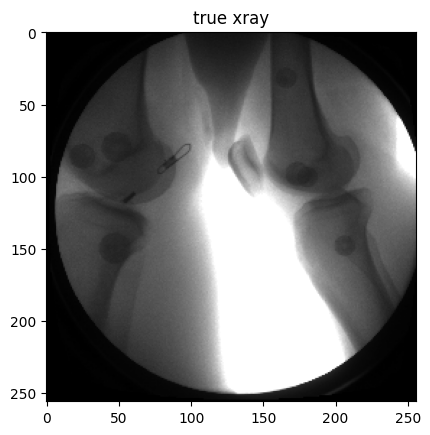

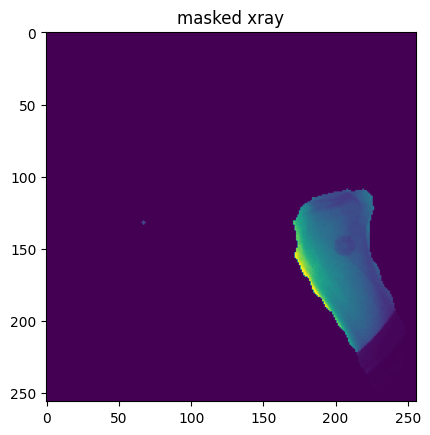

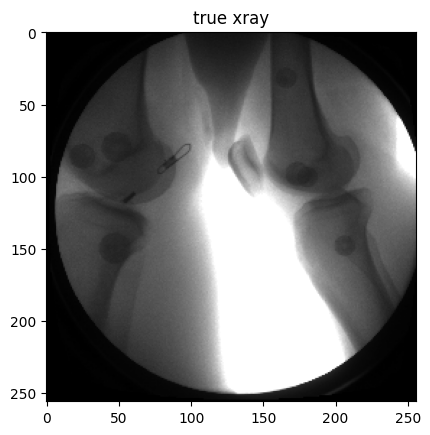

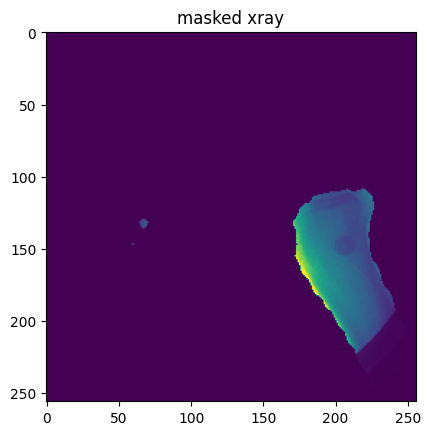

torch.Size([2, 1, 256, 256])
img_tensor torch.float32
img_tensor torch.Size([2, 1, 256, 256])
mask_tensor torch.uint8
mask_tensor torch.Size([2, 256, 256])
1 masks tensor(10479)
2 masks tensor(13148)
zero masks tensor(107445)


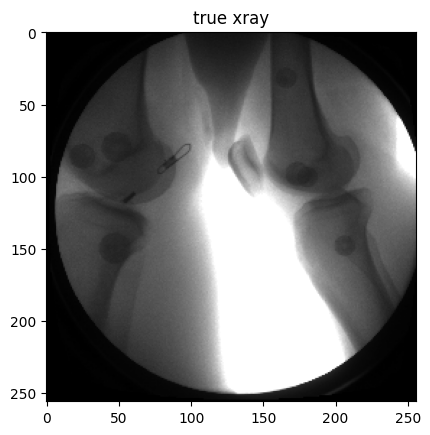

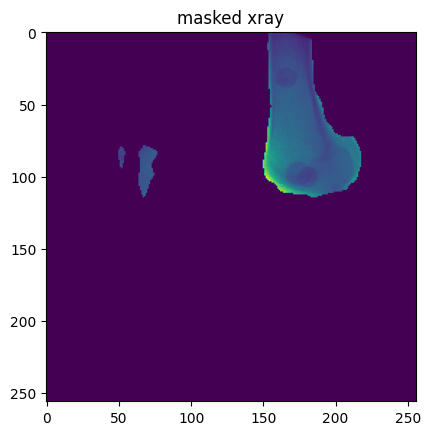

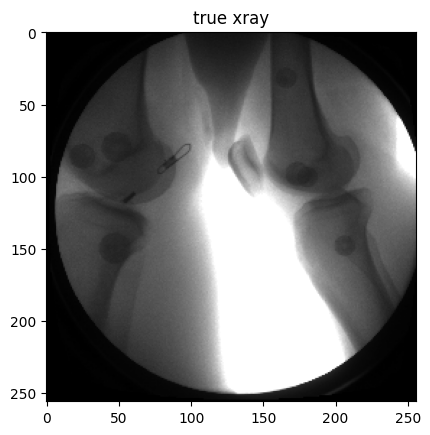

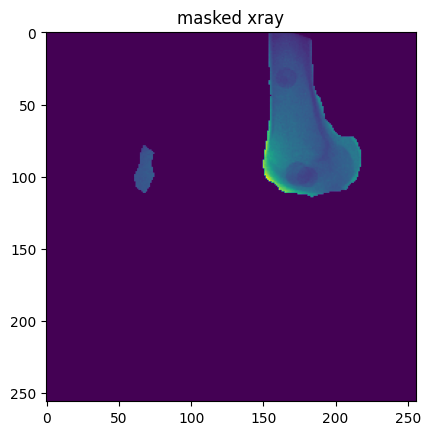

torch.Size([2, 1, 256, 256])


In [56]:
def evaluate_segnet(ckpt, ip):
    plt.imshow(ip[0].cpu()[0], cmap='gray')
    plt.show()
    model = get_deeplab_model(device)
    model.load_state_dict(torch.load(ckpt, weights_only=True))

    with torch.no_grad():
        output = model(ip)['out']  
    print("output", output.shape) 
    output_predictions = output.argmax(1)
    print("output_predictions",output_predictions.shape)

    # show_mask2(output_predictions)


    masks = output_predictions.byte().cpu()

    # test_stack_img = torch.stack([img.to(device), img.to(device)])
    # test_mask_stack = torch.stack([masks, masks])

    crop_tensor = get_masked_img2(ip, masks, 2, device)
    print(crop_tensor.shape)
    # plt.imshow(transforms.ToPILImage()(crop_tensor[0]), cmap='gray', vmin=0, vmax=255)
    # plt.title("Masked Tibia X-Ray")
    # plt.show()


    crop_tensor = get_masked_img2(ip, masks, 1, device)

    print(crop_tensor.shape)
    # plt.imshow(transforms.ToPILImage()(crop_tensor[0]), cmap='gray', vmin=0, vmax=255)
    # plt.title("Masked Femur X-Ray")
    # plt.show()

evaluate_segnet(ckpt = r"checkpoints/segnet_27_9.ckpt", ip= ip)